# As principais modificações realizadas nesse arquivo prático foram na estrutura do VAE, bem como a utilização do MSE ao invés do Binary-CrossEntropy

In [1]:
import tensorflow as tf
import os
import random
import numpy as np

print("Num GPUs: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs:  1


In [2]:
tf.__version__

'2.19.0'

In [3]:
SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [27]:
from tensorflow.keras.datasets import fashion_mnist


(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() # Carrega o dataset Fashion MNIST
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [5]:
dataset = np.concatenate([x_train, x_test], axis=0)
dataset = np.expand_dims(dataset, -1).astype("float32") / 255

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

class SamplingLayer(layers.Layer):
  # aqui aplicaremos a técnica de reparametrização
  def call(self, inputs):
    zMean, zLogVar = inputs
    batch = tf.shape(zMean)[0]
    dim = tf.shape(zMean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return zMean + tf.exp(0.5 * zLogVar) * epsilon

## Encoder / Decoder ##

In [7]:
def buildEncoder(latentDim, encoderInputs):
  # Alterei bastante a parte do Encoder, adicionando mais camadas e alterando as que já existiam
  x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(encoderInputs)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(512, 3, activation="relu", strides=1, padding="same")(x) # Adição de mais uma camada convolucional
  x = layers.BatchNormalization()(x)
  x = layers.Flatten()(x)
  x = layers.Dense(256, activation="relu")(x)
  x = layers.Dropout(0.3)(x)

  zMean = layers.Dense(latentDim, name="z_mean")(x)
  zLogVar = layers.Dense(latentDim, name="z_log_var")(x)
  z = SamplingLayer()([zMean, zLogVar])

  return keras.Model(encoderInputs, [zMean, zLogVar, z], name="encoder")

encoderInputs = keras.Input(shape=(28, 28, 1))
encoder = buildEncoder(16, encoderInputs) # Aumentando o espaço latente para 16 - mais capacidade de representação
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 256) │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 7, 7, 512) │  1,180,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 512) │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  6,422,784 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │      4,112 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │      4,112 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_layer      │ (None, 16)        │          0 │ z_mean[0][0],     │
│ (SamplingLayer)     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,984,672 (30.46 MB)

 Trainable params: 7,982,752 (30.45 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [8]:
def buildDecoder(latentInputs):
  x = layers.Dense(7*7*256, activation="relu")(latentInputs)
  x = layers.Reshape((7, 7, 256))(x)
  x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
  return keras.Model(latentInputs, x, name="decoder")

latentInputs = keras.Input(shape=(16,))
decoder = buildDecoder(latentInputs)
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12544)          │       213,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           577 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 583,425 (2.23 MB)

 Trainable params: 583,041 (2.22 MB)

 Non-trainable params: 384 (1.50 KB)

## Loss Functions ##

In [9]:
def reconstructionLoss(data, reconstructed):
  return tf.reduce_mean(
      tf.reduce_sum(
          tf.keras.losses.binary_crossentropy(data, reconstructed), # Alterando de binary_crossentropy para mse
          axis=(1, 2)
      )
  )

In [10]:
def reconstructionLossmse(data, reconstructed):
  return tf.reduce_mean(
      tf.reduce_sum(
          tf.keras.losses.mse(data, reconstructed), # Alterando de binary_crossentropy para mse
          axis=(1, 2)
      )
  )

In [12]:
def klDivergenceLoss(zMean, zLogVar):
  return tf.reduce_mean(
      tf.reduce_sum(
          -0.5 * (1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar)), # KL Divergence Loss que foi comentado nas aulas
          axis=1
      )
  )

In [11]:
def calcTotalLoss(data, reconstructed, zMean, zLogVar): # função que calcula a perda total do VAE, analisando a reconstrução e o quão distante estamos da distribuição normal
  # loss1 = reconstructionLoss(data, reconstructed)
  loss1 = reconstructionLossmse(data, reconstructed)
  loss2 = klDivergenceLoss(zMean, zLogVar)
  klWeight = 3.0
  return  loss1, loss2, loss1 + klWeight * loss2 # retornamos a perda de reconstrução, a perda KL e a perda total ponderada

In [13]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super().__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.totalLossTracker = keras.metrics.Mean(name="total_loss")
    self.ceLossTracker = keras.metrics.Mean(name="ce_loss")
    self.klLossTracker = keras.metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
    return [self.totalLossTracker, self.ceLossTracker, self.klLossTracker]

  def train_step(self, data):
    with tf.GradientTape() as tape:
      zMean, zLogVar, z = self.encoder(data)
      reconstruction = self.decoder(z)
      ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstruction, zMean, zLogVar)
    grads = tape.gradient(totalLoss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    self.totalLossTracker.update_state(totalLoss)
    self.ceLossTracker.update_state(ceLoss)
    self.klLossTracker.update_state(klLoss)

    return {
      "total_loss": self.totalLossTracker.result(),
      "ce_loss": self.ceLossTracker.result(),
      "kl_loss": self.klLossTracker.result()
    }

# Utilizando o Binary-CrossEntropy

In [15]:
# Treinando o modelo com o binary-cross entropy
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001)) # Alterado o learning rate para 1e-4, ao invés de 1e-3
history = vae.fit(dataset, epochs=32, batch_size=128)

Epoch 1/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - ce_loss: 394.6618 - kl_loss: 4.4182 - total_loss: 407.9165
Epoch 2/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - ce_loss: 260.0288 - kl_loss: 7.9982 - total_loss: 284.0234
Epoch 3/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - ce_loss: 250.7344 - kl_loss: 7.8862 - total_loss: 274.3930
Epoch 4/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - ce_loss: 246.6685 - kl_loss: 7.9114 - total_loss: 270.4027
Epoch 5/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - ce_loss: 244.6766 - kl_loss: 7.9273 - total_loss: 268.4586
Epoch 6/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - ce_loss: 243.1319 - kl_loss: 7.9790 - total_loss: 267.0690
Epoch 7/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - ce_loss: 241.9813 - kl_loss: 8.0288 - total_loss: 266.0679
Epoch 8/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - ce_loss: 240.9884 - kl_loss: 8.0725 - total_loss: 265.2059
Epoch 9/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - ce_loss: 240.1048 - kl_l

# Utilizando o MSE

In [14]:
# Treinando o modelo com o MSE
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))
history = vae.fit(dataset, epochs=32, batch_size=128)

Epoch 1/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - ce_loss: 79.8022 - kl_loss: 1.3997 - total_loss: 84.0013
Epoch 2/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - ce_loss: 31.4043 - kl_loss: 3.7321 - total_loss: 42.6004
Epoch 3/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - ce_loss: 27.8655 - kl_loss: 3.8784 - total_loss: 39.5007
Epoch 4/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - ce_loss: 26.2635 - kl_loss: 3.9443 - total_loss: 38.0963
Epoch 5/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - ce_loss: 25.3845 - kl_loss: 3.9898 - total_loss: 37.3540
Epoch 6/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - ce_loss: 24.9272 - kl_loss: 3.9889 - total_loss: 36.8940
Epoch 7/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - ce_loss: 24.5425 - kl_loss: 4.0005 - total_loss: 36.5440
Epoch 8/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - ce_loss: 24.2753 - kl_loss: 4.0213 - total_loss: 36.3391
Epoch 9/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - ce_loss: 24.0966 - kl_loss: 4.0168 - tot

# Utilizando o Binary-CrossEntropy

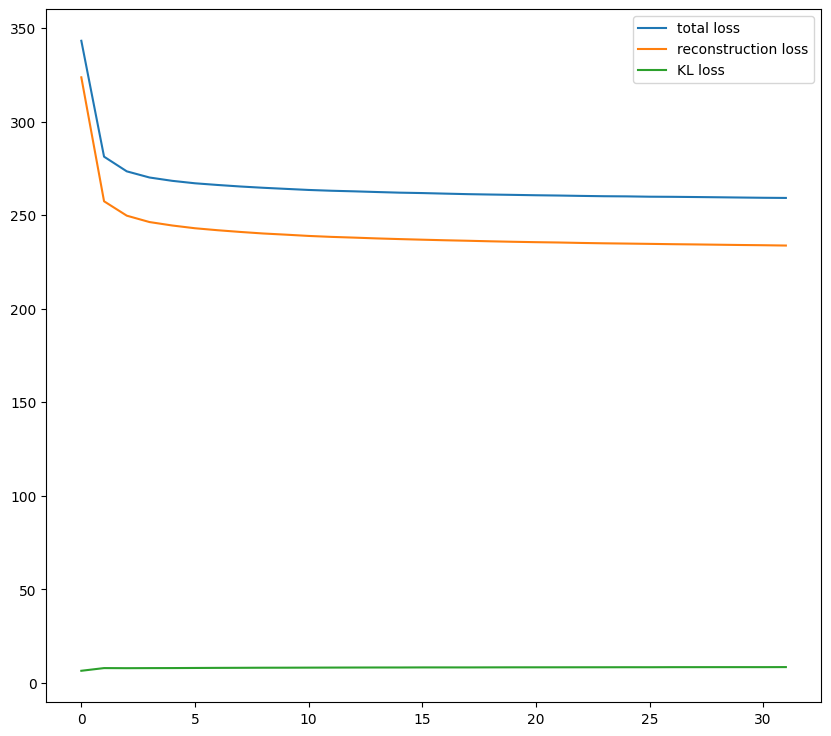

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 9))
plt.plot(history.history.get('total_loss'), label="total loss")
plt.plot(history.history.get('ce_loss'), label="reconstruction loss")
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

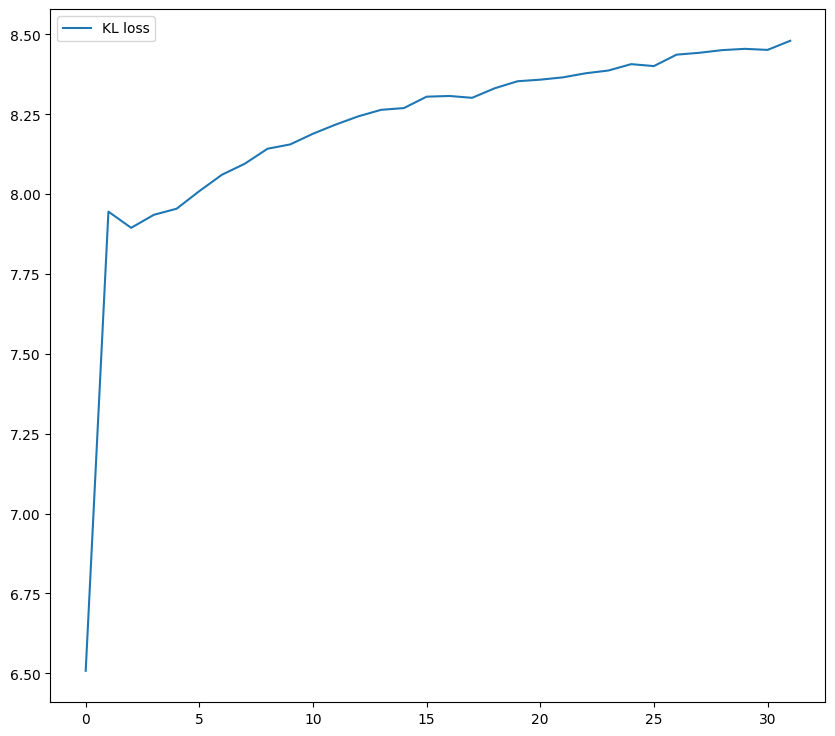

In [18]:
plt.figure(figsize=(10, 9))
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

# Utilizando o MSE

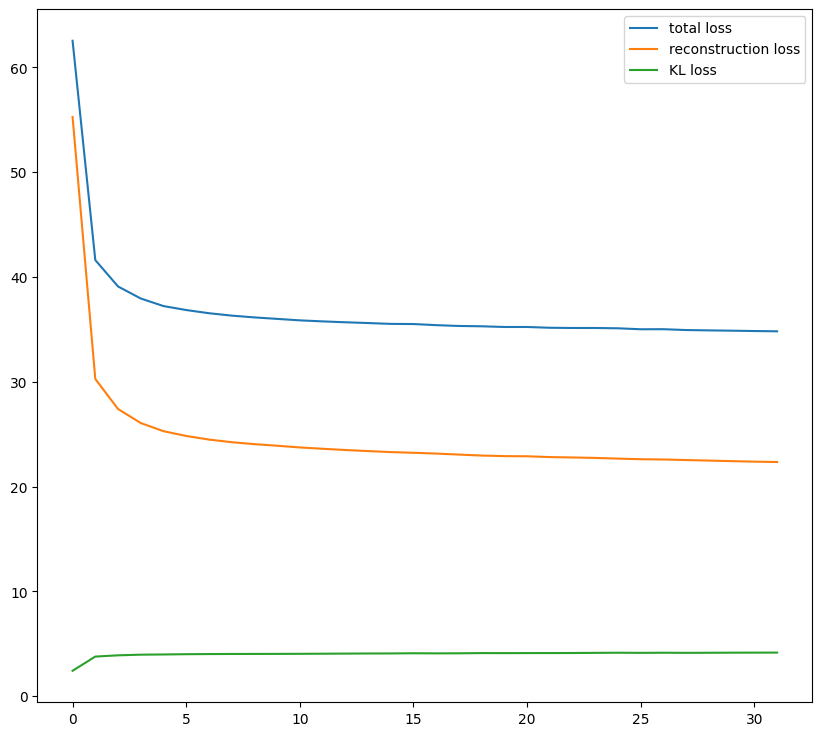

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 9))
plt.plot(history.history.get('total_loss'), label="total loss")
plt.plot(history.history.get('ce_loss'), label="reconstruction loss")
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();
# Note que como a métrica é diferente, a loss está muito mais baixa, mas não dá pra levar isso em consideração

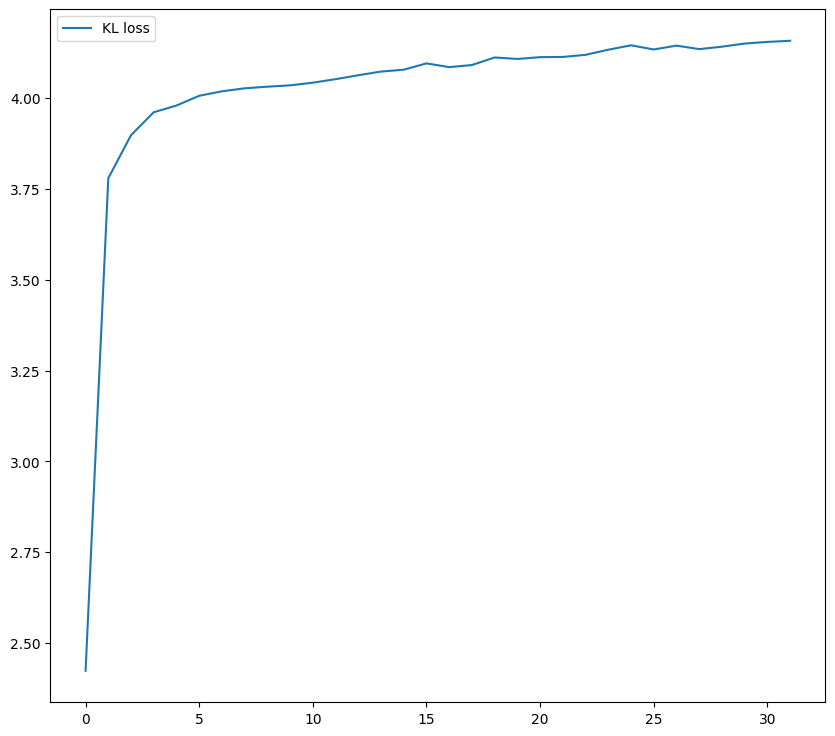

In [16]:
plt.figure(figsize=(10, 9))
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


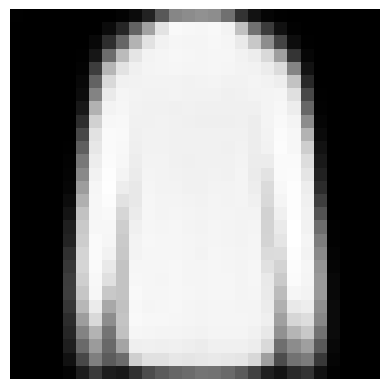

In [22]:
# Precisamos fornecer um vetor latente de dimensão 16 para o decoder
# Utilizando o MSE
z = np.random.normal(loc=0, scale=1, size=(1, 16))
synth = vae.decoder.predict(z)
plt.axis('off')
plt.imshow(synth.reshape((28,28)), cmap="Greys_r");

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


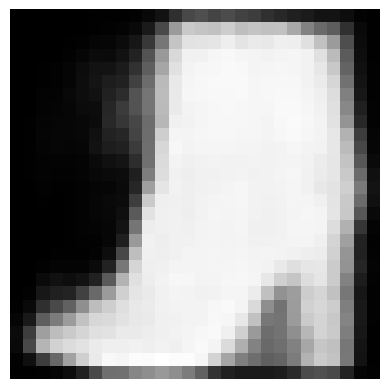

In [20]:
# Utilizando o Binary-CrossEntropy
z = np.random.normal(loc=0, scale=1, size=(1, 16))
synth = vae.decoder.predict(z)
plt.axis('off')
plt.imshow(synth.reshape((28,28)), cmap="Greys_r");

# Utilizando o Binary-CrossEntropy

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  


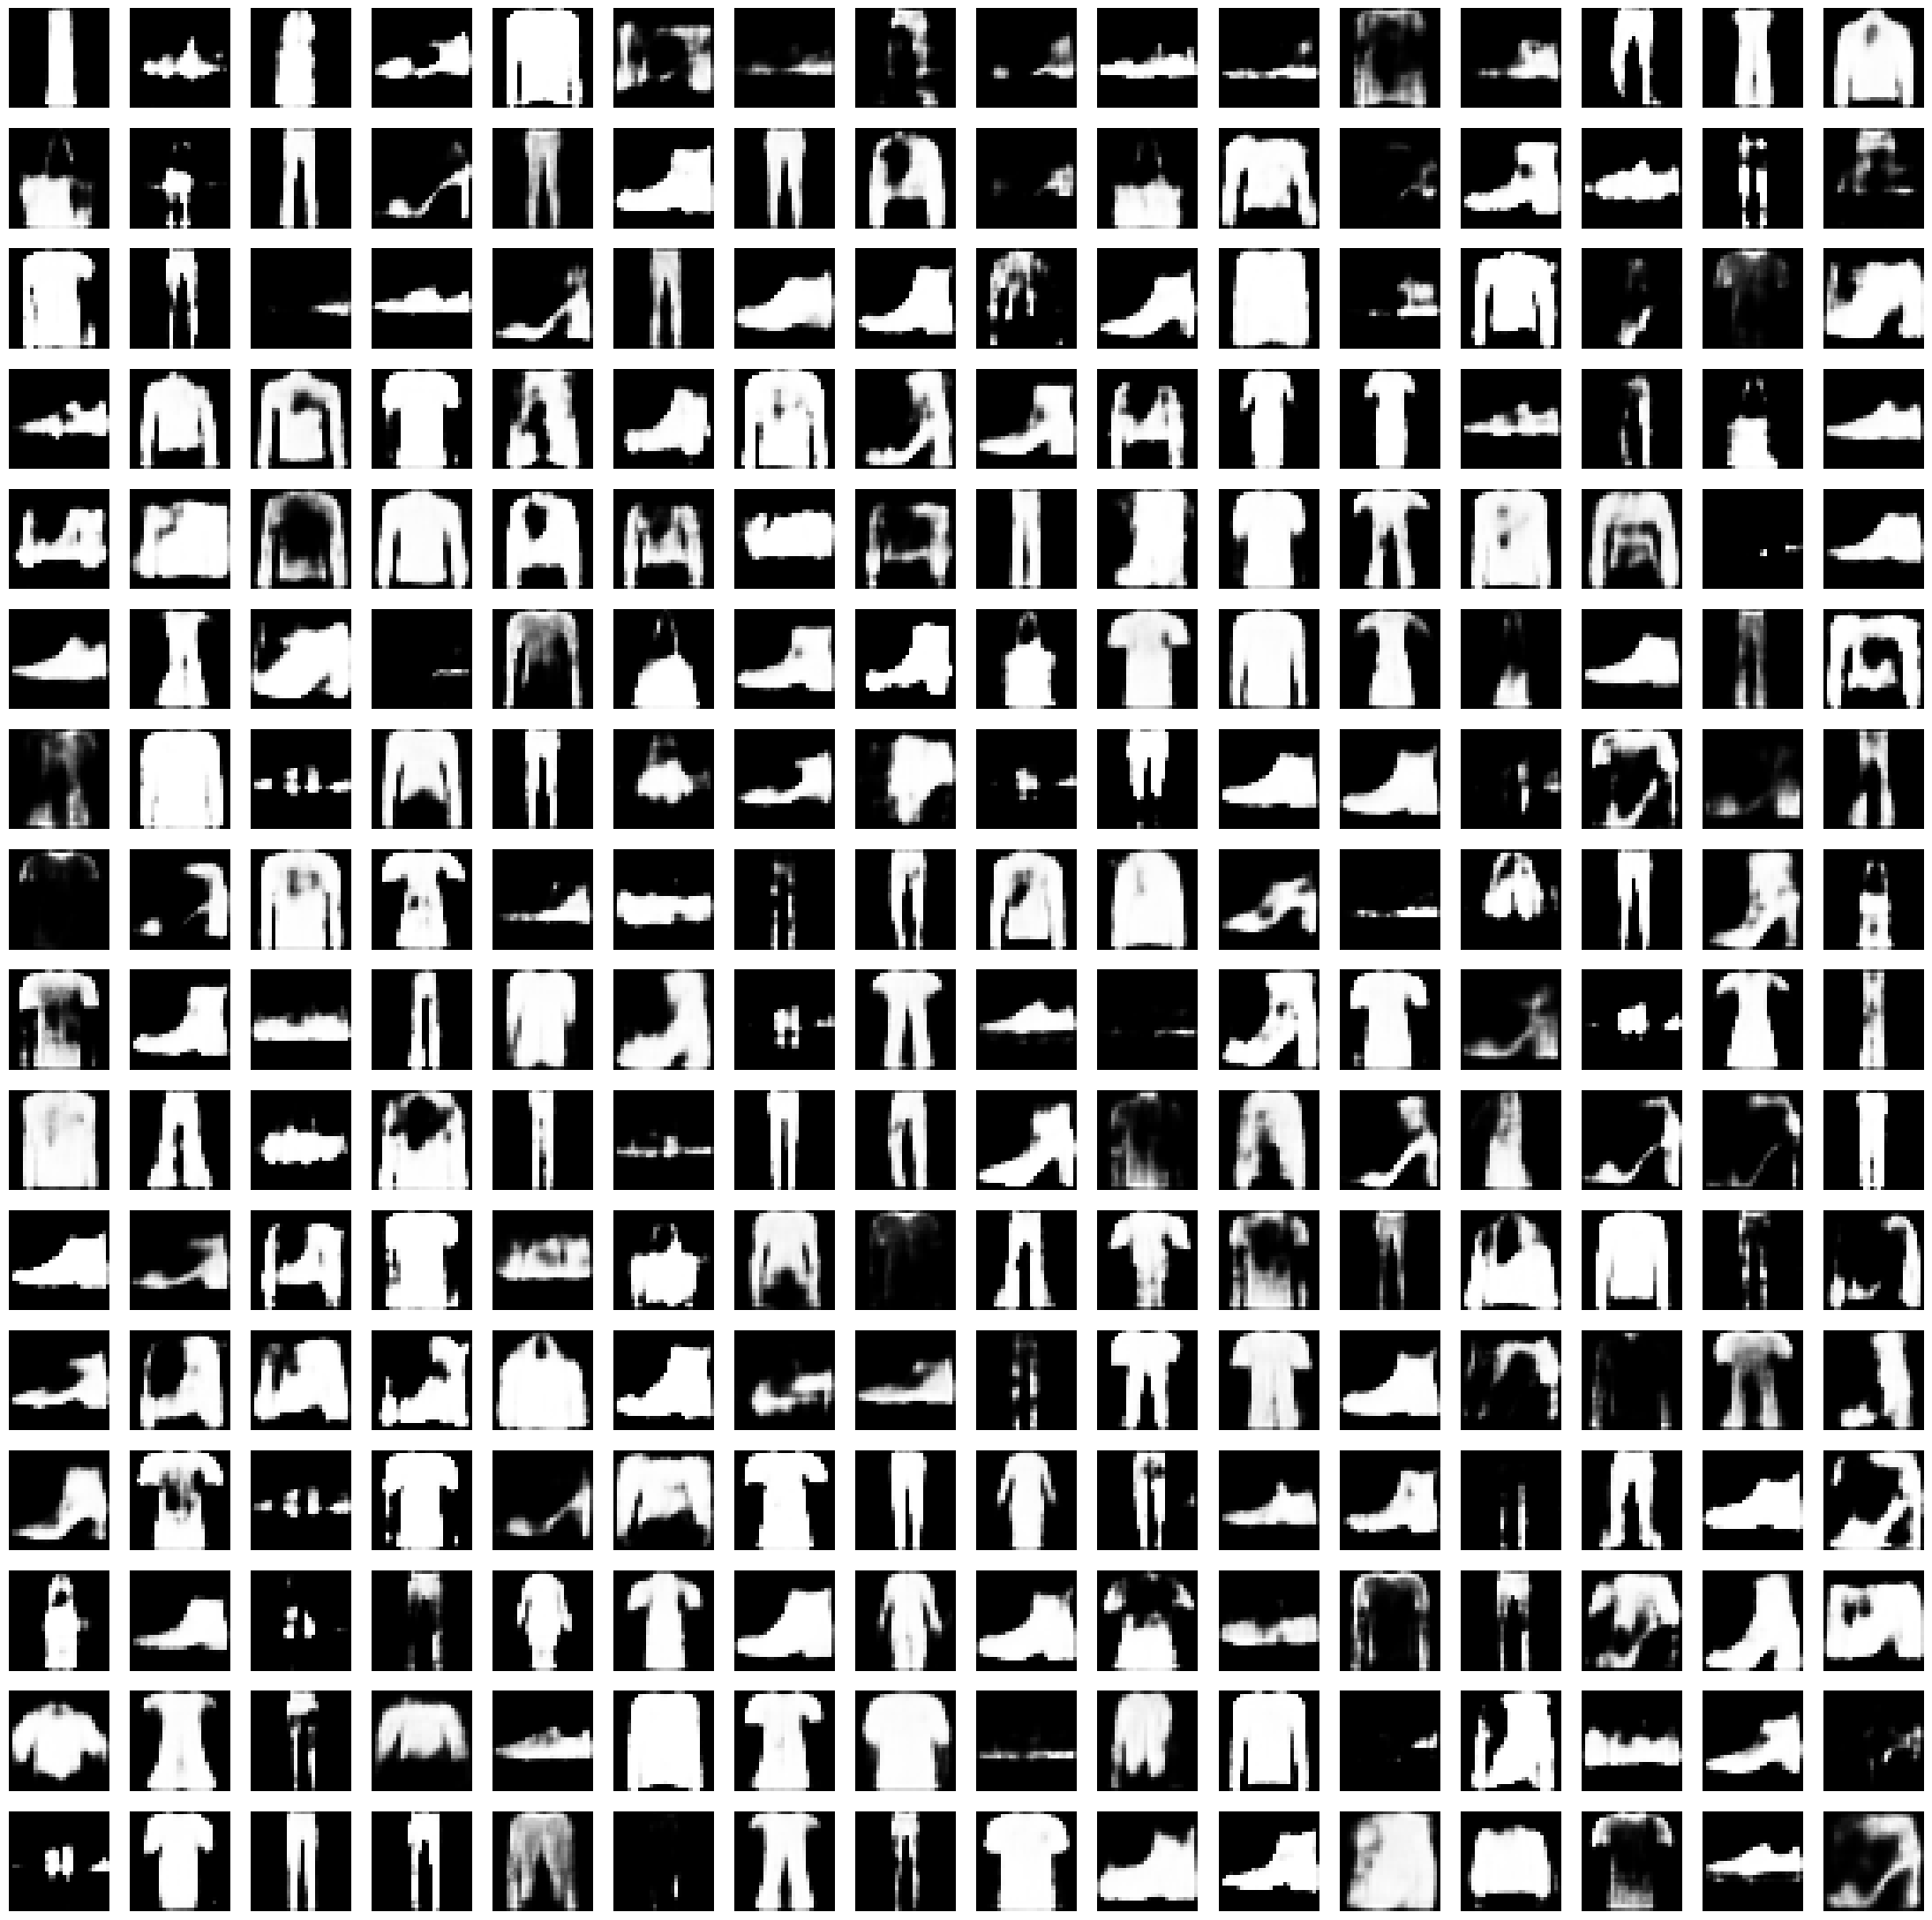

In [22]:
z = np.random.normal(loc=0, scale=4, size=(256,16))
synth = vae.decoder.predict(z) # Gerando 256 imagens a partir do espaço latente

plt.figure(figsize=(28,28))

for i in range(256):
    plt.subplot(16,16,i+1) # organizando as imagens em uma grade 16x16
    plt.imshow(synth[i].reshape((28,28)), cmap="Greys_r")
    plt.axis('off')

plt.show();
# Podemos verificar que o modelo conseguiu gerar imagens razoavelmente boas, mesmo com um espaço latente tão pequeno (2D).

# Utilizando o MSE

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  


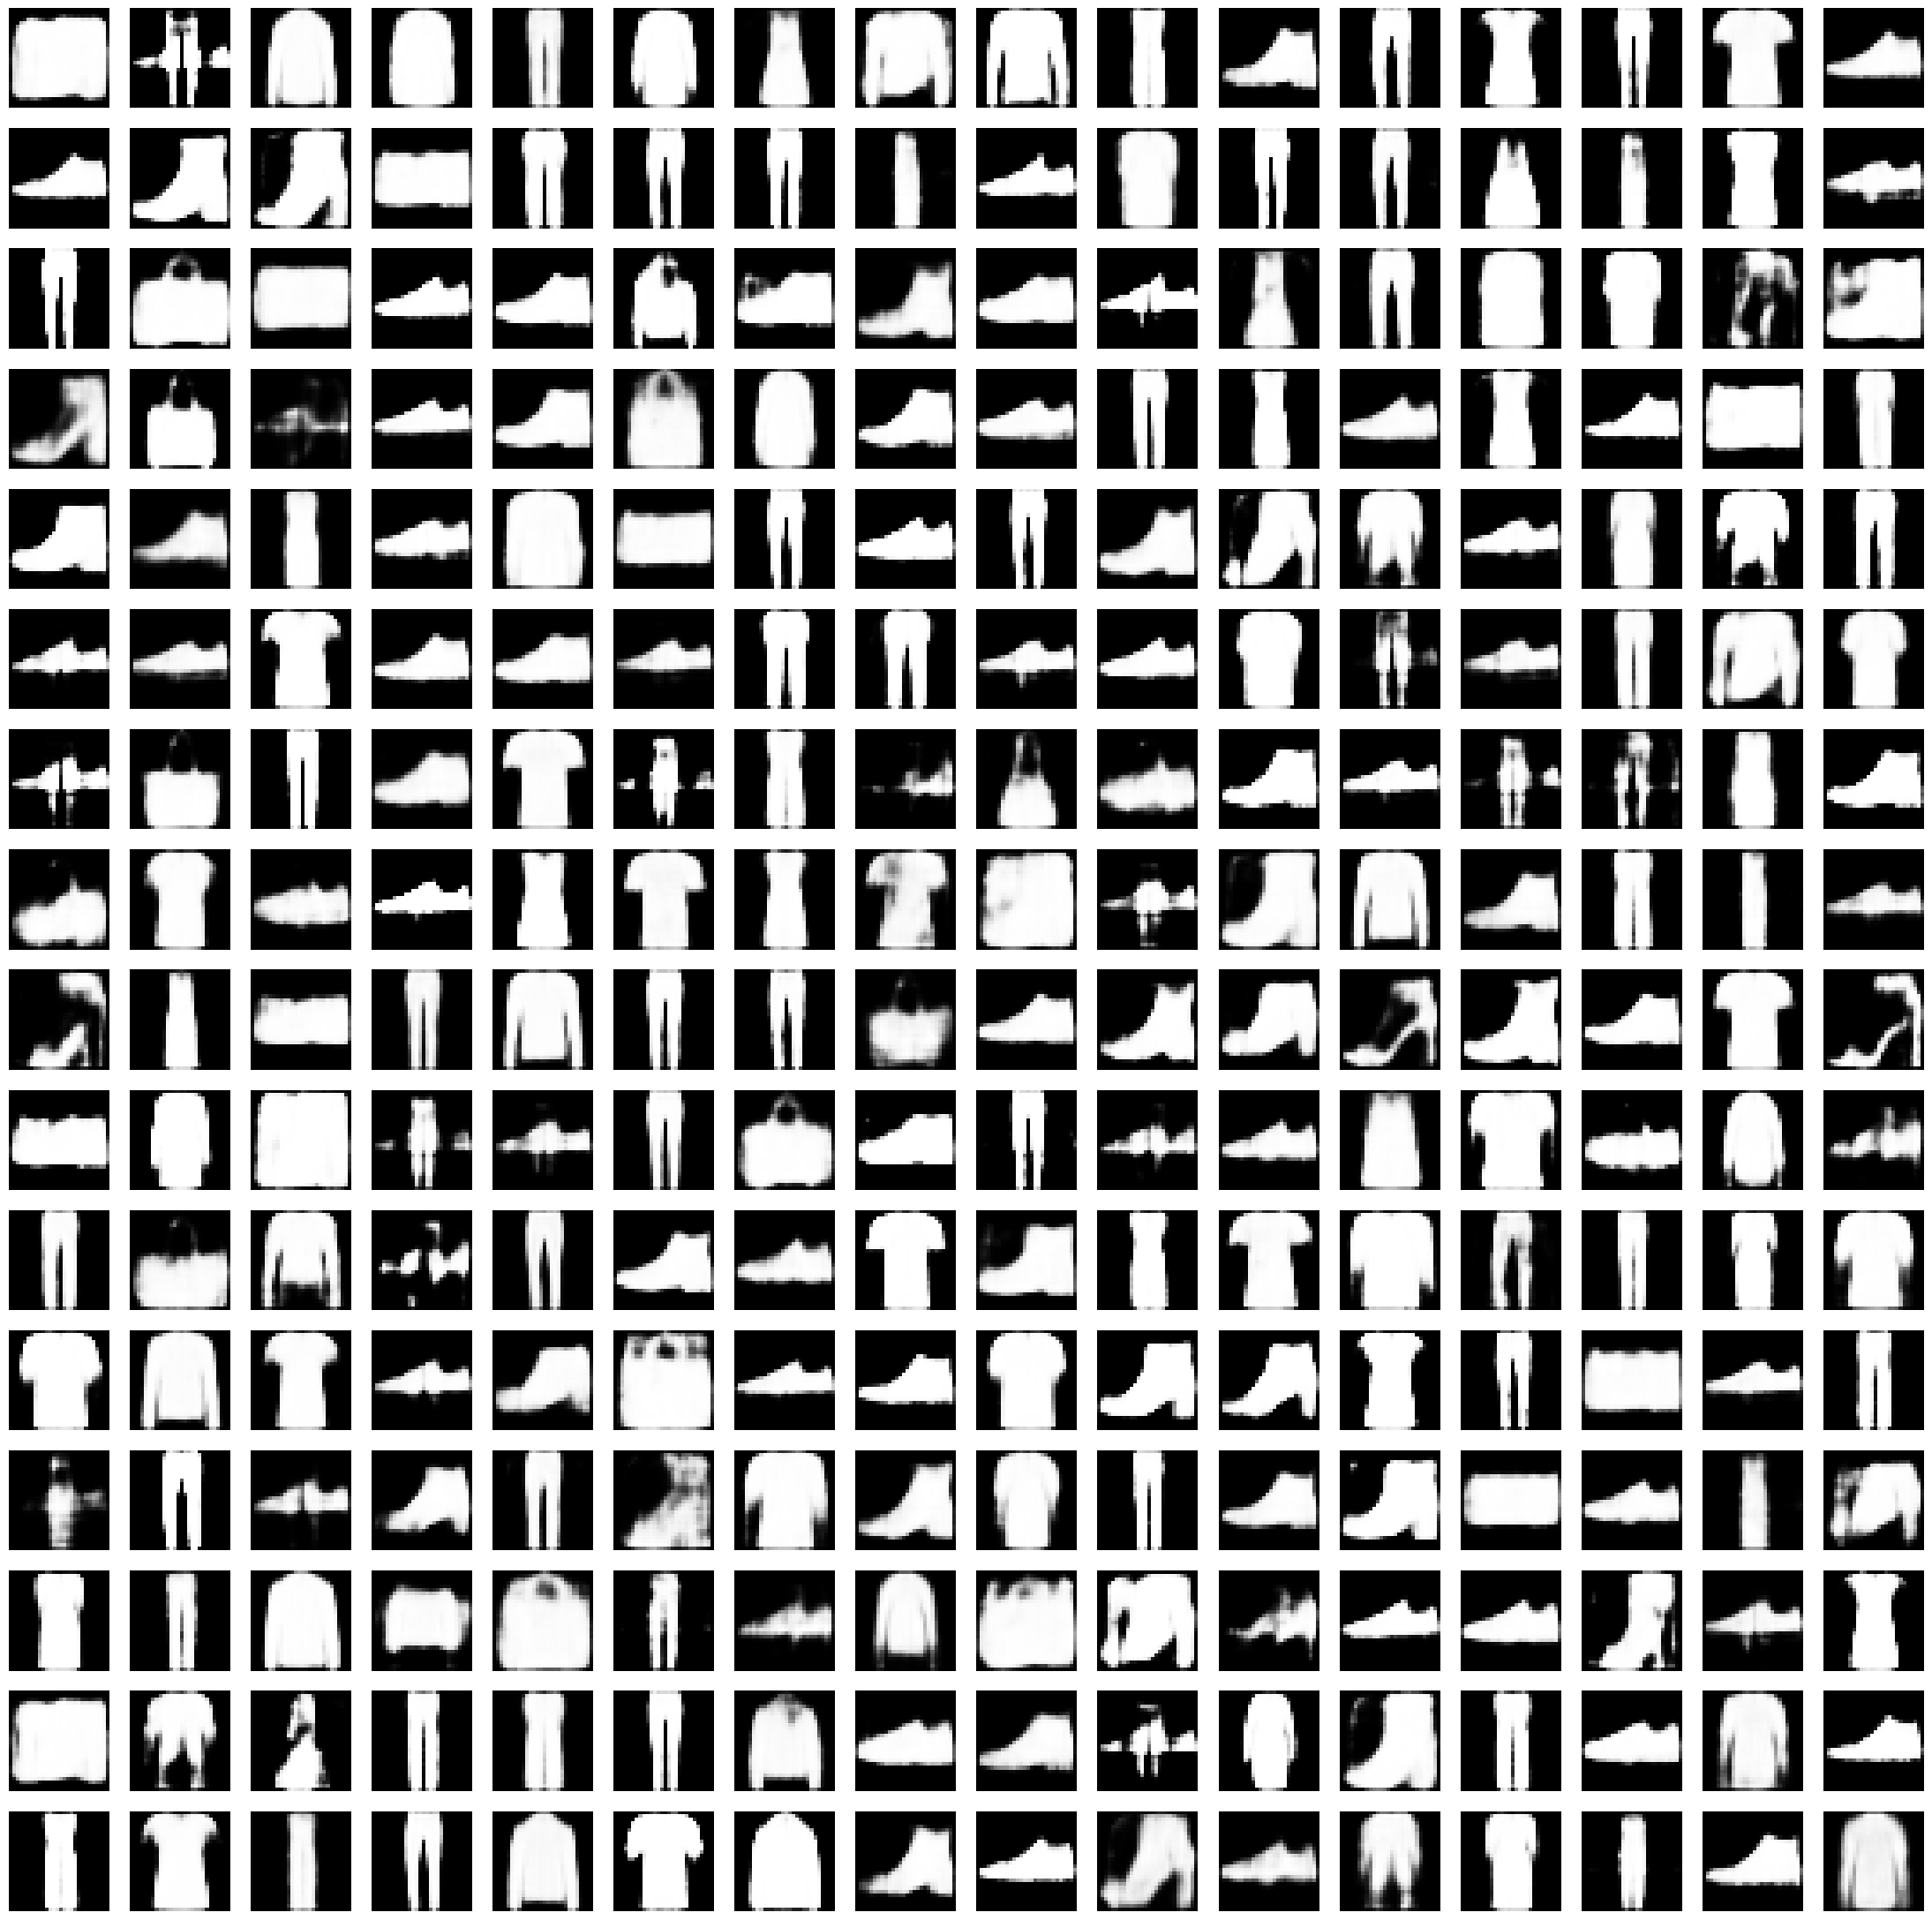

In [23]:
z = np.random.normal(loc=0, scale=4, size=(256,16))
synth = vae.decoder.predict(z) # Gerando 256 imagens a partir do espaço latente

plt.figure(figsize=(28,28))

for i in range(256):
    plt.subplot(16,16,i+1) # organizando as imagens em uma grade 16x16
    plt.imshow(synth[i].reshape((28,28)), cmap="Greys_r")
    plt.axis('off')

plt.show();
# Podemos verificar que o modelo conseguiu gerar imagens razoavelmente boas, mesmo com um espaço latente tão pequeno (2D).

In [26]:
# Vamos agora pegar uma imagem do dataset e ver como o modelo a representa no espaço latente
idx = 350 # índice da imagem que queremos analisar
batch = np.expand_dims(x_train[idx], axis=0) # expandindo as dimensões para criar um batch de tamanho 1
batchOfImages = np.expand_dims(batch, axis=-1).astype("float32") / 255 # normalizando a imagem
print(batchOfImages.shape)
_, _, z = vae.encoder.predict(batchOfImages)

synth = vae.decoder.predict([z])

z

(1, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


array([[ 1.3106451 , -0.28772625, -0.62679833,  0.51858133, -0.73466027,
         0.6528443 ,  2.3833175 , -1.3353364 , -0.2537729 , -0.34118018,
         2.4038599 , -0.4361624 , -0.27861696,  0.02743421, -0.74334323,
        -1.2342541 ]], dtype=float32)

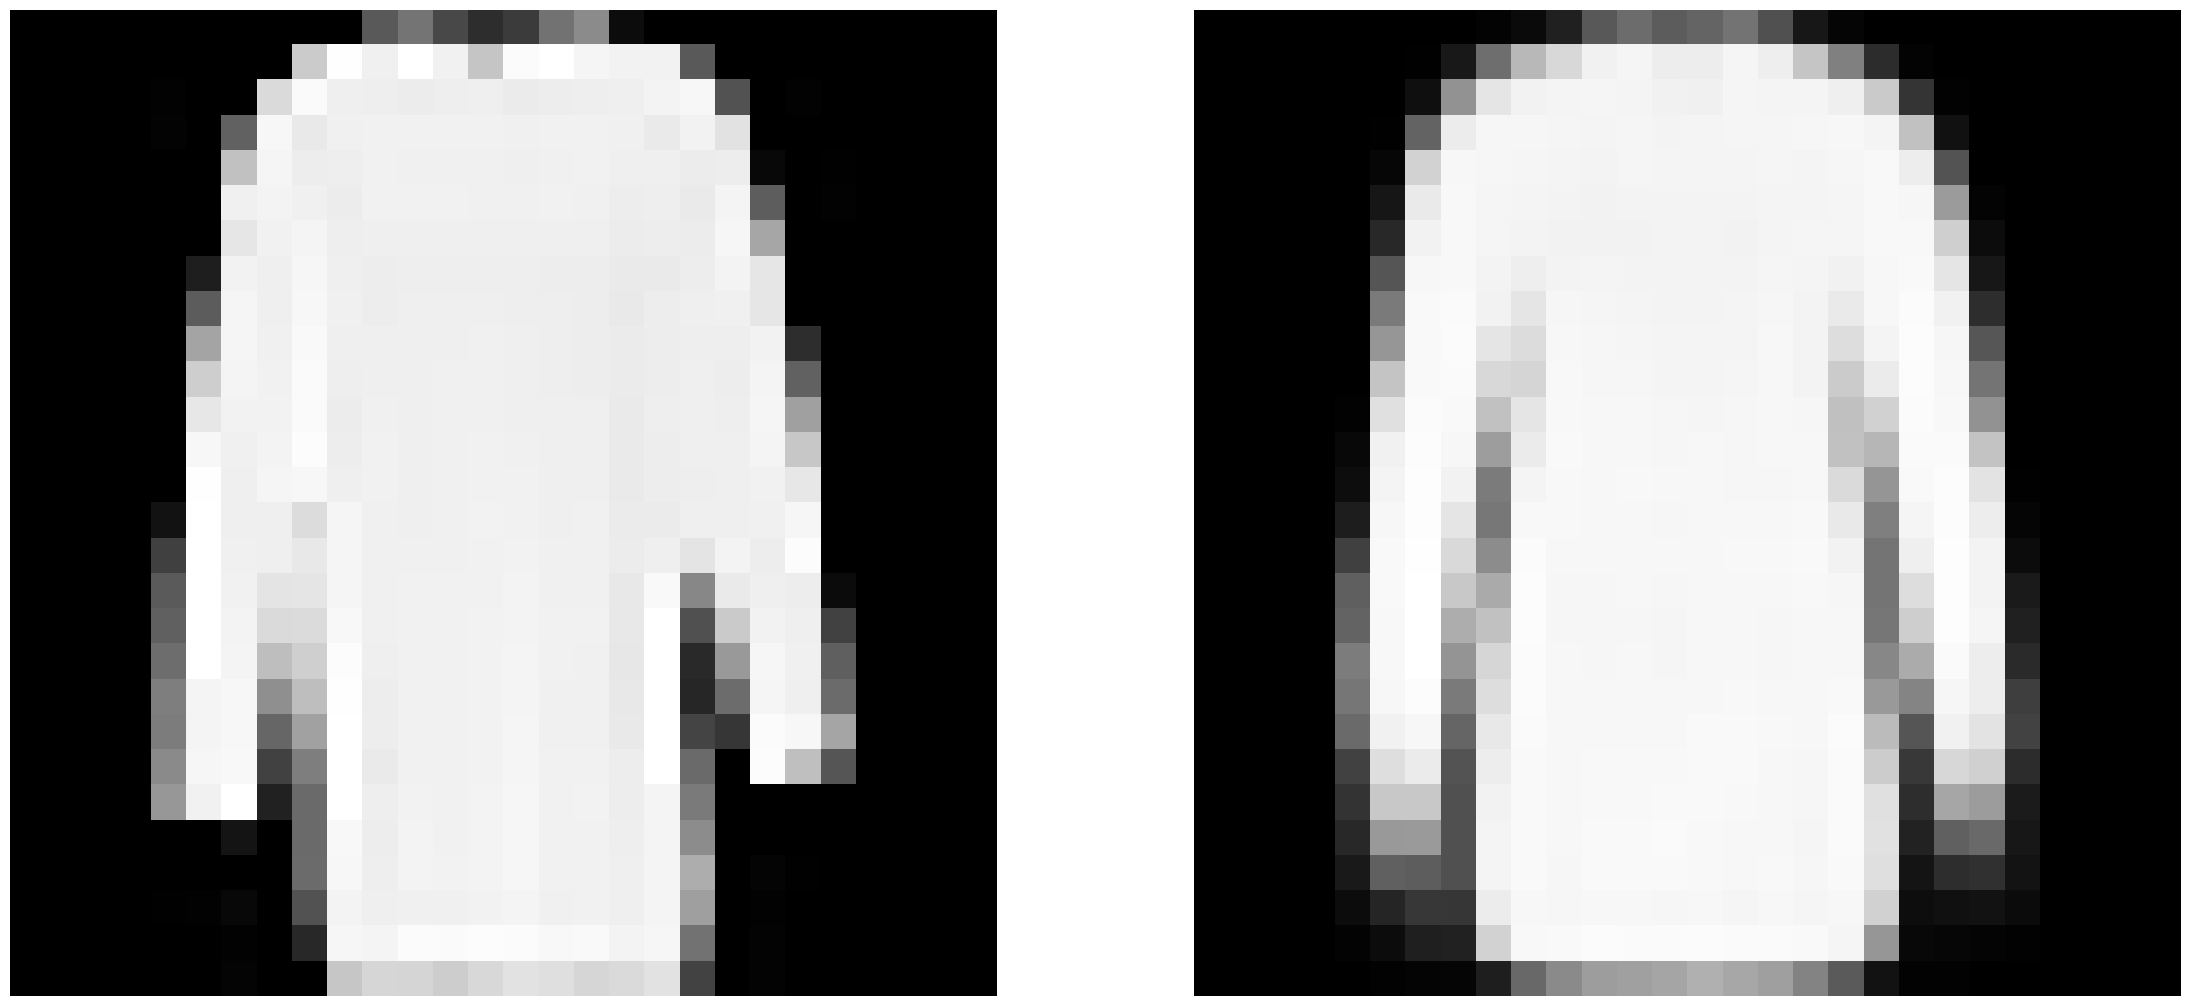

In [27]:
plt.figure(figsize=(28, 28))

# original image
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(x_train[idx], cmap="Greys_r")


# reconstructed
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(synth[0].reshape((28,28)), cmap="Greys_r")
plt.show();

In [24]:
# Vamos agora pegar uma imagem do dataset e ver como o modelo a representa no espaço latente
idx = 350 # índice da imagem que queremos analisar
batch = np.expand_dims(x_train[idx], axis=0) # expandindo as dimensões para criar um batch de tamanho 1
batchOfImages = np.expand_dims(batch, axis=-1).astype("float32") / 255 # normalizando a imagem
print(batchOfImages.shape)
_, _, z = vae.encoder.predict(batchOfImages)

synth = vae.decoder.predict([z])

z

(1, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_15
Received: inputs=('Tensor(shape=(1, 16))',)
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


array([[ 1.6752383 ,  0.07757393, -1.297251  , -0.68986   , -0.37000373,
        -0.29650152,  1.8436794 ,  0.34433666, -0.36990142, -0.37656057,
         0.33584422,  0.9486947 , -0.17630422, -1.320251  , -1.6971096 ,
        -0.9867783 ]], dtype=float32)

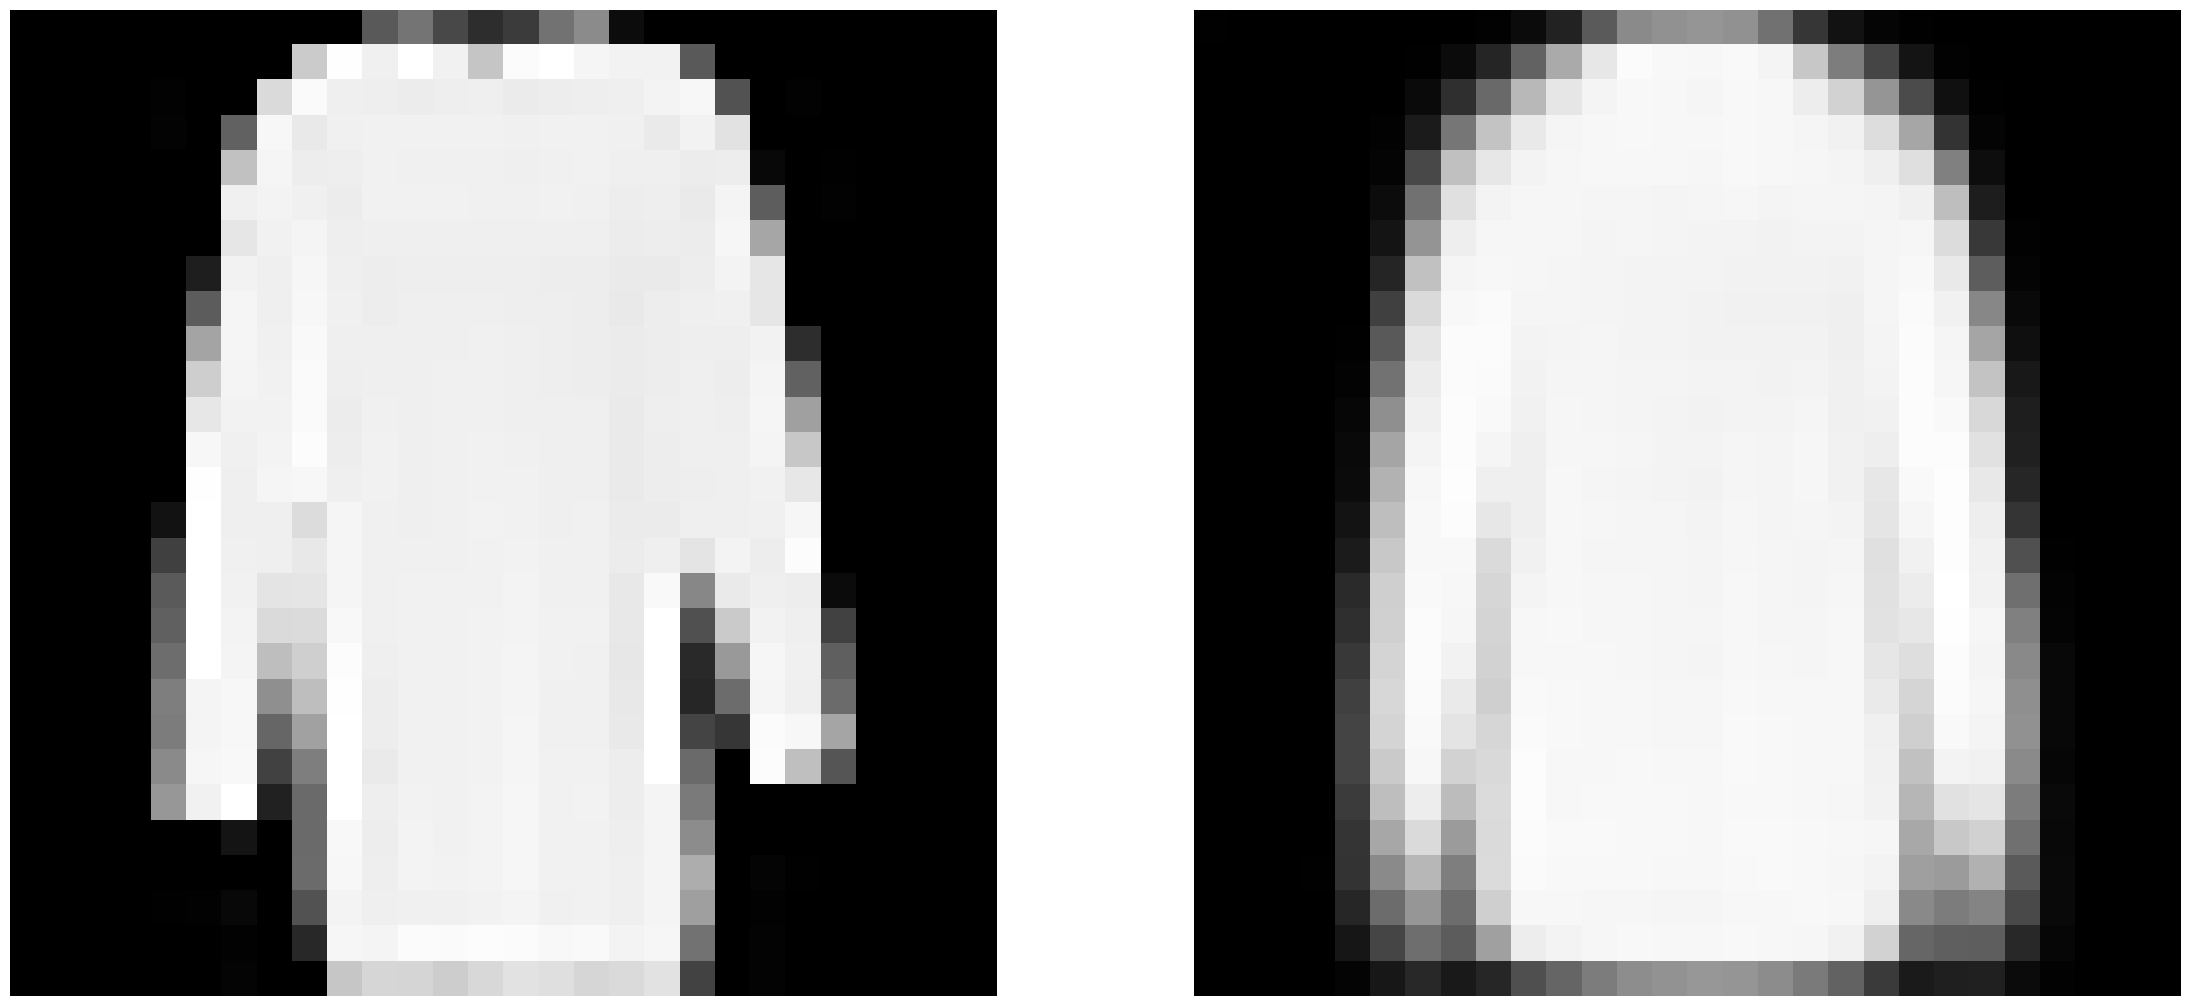

In [25]:
plt.figure(figsize=(28, 28))

# original image
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(x_train[idx], cmap="Greys_r")


# reconstructed
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(synth[0].reshape((28,28)), cmap="Greys_r")
plt.show();

2188/2188 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


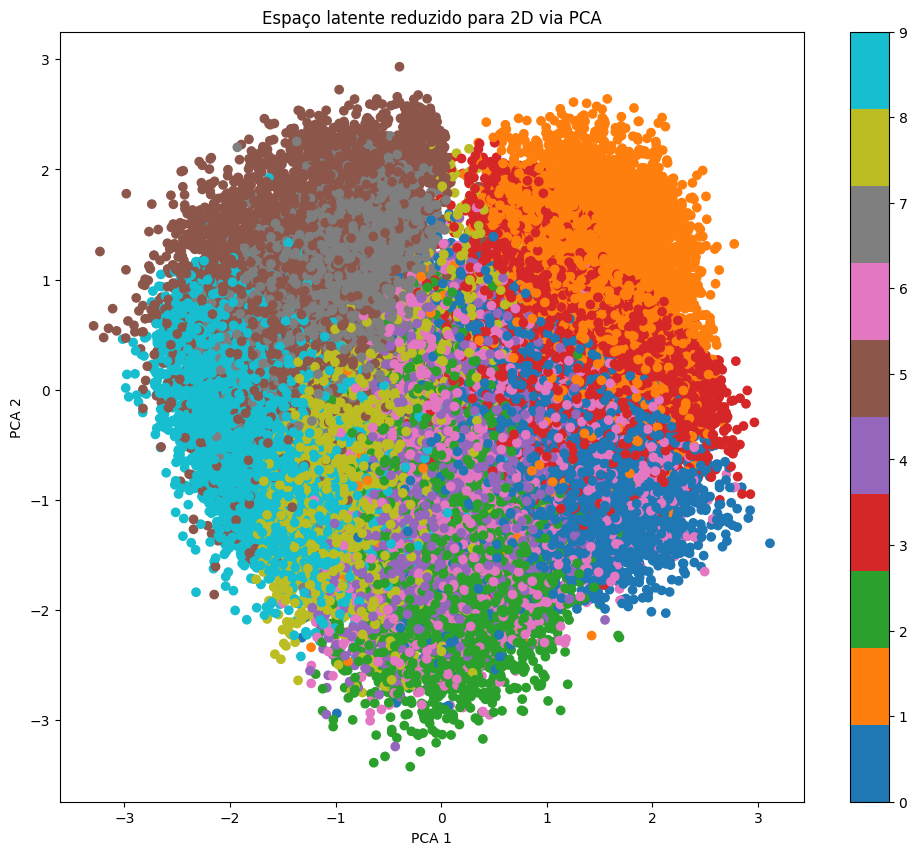

In [28]:
from sklearn.decomposition import PCA

# Calcula as médias latentes para todo o dataset
meu, _, _ = vae.encoder.predict(dataset)

# Reduz para 2 dimensões usando PCA
pca = PCA(n_components=2)
meu_pca = pca.fit_transform(meu)

plt.figure(figsize=(12, 10))
plt.scatter(meu_pca[:, 0], meu_pca[:, 1], c=labels, cmap='tab10')
plt.colorbar()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Espaço latente reduzido para 2D via PCA")
plt.show();